In [28]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import holidays

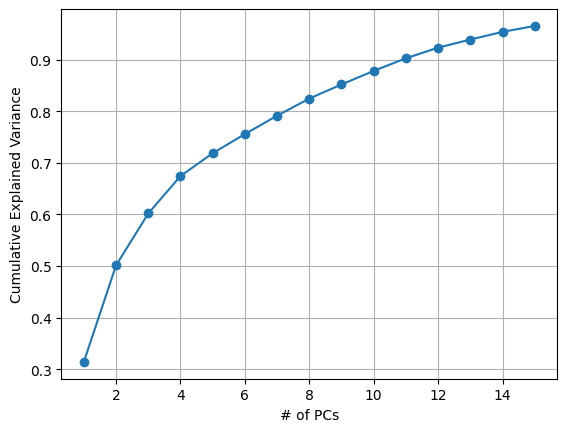

,date,holiday,moon,arrest,num_crimes,wd,wPC1,wPC2,wPC3,wPC4,wPC5,wPC6,wPC7,wPC8,wPC9,wPC10
0,2010-01-01,New Year's Day,0.0,0.216216,74,Friday,5.288267,-3.436754,-1.934383,-1.600636,-0.696136,-0.241663,1.004215,-0.902615,0.690424,0.769404
1,2010-01-02,NaN,0.0,0.431373,51,Saturday,5.641923,-3.922099,-1.749891,0.514432,-0.514421,-0.576854,0.301494,-0.932726,0.739275,0.646302
2,2010-01-03,NaN,0.0,0.340909,44,Sunday,5.507165,-3.413418,-1.835230,0.129064,-0.829287,-0.590793,0.545550,-0.652679,0.542035,0.667098
3,2010-01-04,NaN,0.0,0.403846,52,Monday,5.541065,-2.051329,-1.750209,-0.447364,-1.676369,-0.456364,1.196762,-0.052274,0.074147,0.563735
4,2010-01-05,NaN,0.0,0.557692,52,Tuesday,4.669759,-2.226177,-2.045199,-1.743264,-1.387959,-0.503360,1.536731,-0.253174,0.040207,0.699972


In [29]:
crimes = pd.read_csv('../Crimes.csv')
moon = pd.read_csv('../full_moon.csv')
weather = pd.read_csv('../weather.csv')

crimes['ds'] = pd.to_datetime(crimes['Date']).dt.date
crimes['ds'] = pd.to_datetime(crimes['ds'], format="%Y-%m-%d")
crimes['time'] = crimes['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y %I:%M:%S %p").time())
crimes = crimes.drop(columns=['Date', 'ID', 'Case Number', 'Location', 'Updated On'])

jan2024 = pd.DataFrame(
{
    'ds': ['2024-01-25'],
    'moon':[1]
}
)
moon['ds'] = pd.to_datetime(moon['FullMoonDates']).dt.date
moon['ds'] = pd.to_datetime(moon['ds'], format="%Y-%m-%d")
moon = moon.drop(columns=['FullMoonDates', 'Year'])
moon = pd.concat([moon, jan2024], ignore_index=True)
moon['ds'] = pd.to_datetime(moon['ds'], format="%Y-%m-%d")

moon['moon'] = 1
moon = moon[['ds', 'moon']]


weather['ds'] = pd.to_datetime(weather['datetime'])
weather['ds'] = pd.to_datetime(weather['ds'], format="%Y-%m-%d")
weather = weather.drop(columns=['datetime', 'stations', 'name', 'conditions', 'description'])
weather['sunrise'] = weather['sunrise'].apply(lambda x: datetime.fromisoformat(x).timestamp())
weather['sunset'] = weather['sunset'].apply(lambda x: datetime.fromisoformat(x).timestamp())
weather['windgust'] = weather['windgust'].fillna(0)
weather['severerisk'] = weather['severerisk'].fillna(0)
weather['preciptype'] = weather['preciptype'].fillna('none')

numeric_transformer = Pipeline(
    steps=[
        ('scale', StandardScaler()),
    ]
)
cat_transformer = Pipeline(
    steps=[
        ('onehot', OneHotEncoder())
    ]
)

pre = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_include=['float64', 'int64'])),
        ('cat', cat_transformer, selector(dtype_exclude=['float64', 'int64']))
    ]
)

wp = Pipeline(
    steps=[
        ('preprocessor', pre),
        ('pca', PCA(n_components=15))
    ]
)



dates = weather['ds']
w_train = weather.drop(columns=['ds'])
pcs = wp.fit_transform(w_train)
e_var = wp.named_steps['pca'].explained_variance_ratio_
e_var = np.cumsum(e_var)
plt.plot(np.arange(1, len(e_var)+1), e_var, marker='o', linestyle='-')
plt.grid(visible=True)
plt.xlabel('# of PCs')
plt.ylabel('Cumulative Explained Variance')
plt.show()
pc_keep = 10
valuable_pcs = [sub_arr[:pc_keep] for sub_arr in pcs]
valuable_pcs = pd.DataFrame(valuable_pcs, columns=[f'wPC{i}' for i in range(1,pc_keep+1)])
valuable_pcs['ds'] = dates
weather_r = valuable_pcs

# Using a different holiday calendar
holidays_calendar = pd.DataFrame()
for date, name in sorted(holidays.US(years=list(range(2001, 2025))).items()):
    holidays_calendar = pd.concat([holidays_calendar, pd.DataFrame(data=[[date, name]], columns=['ds', 'holiday'])])
    
holidays_calendar.drop_duplicates(subset=['ds', 'holiday'], inplace=True)
holidays_calendar = holidays_calendar[['holiday', 'ds']]
covid_calendar_initial = pd.DataFrame({'holiday': 'COVID First Rush', 'ds': pd.date_range(start='2/14/2020', end='3/15/2020')})
covid_calendar_rush = pd.DataFrame({'holiday': 'COVID First Rush', 'ds': pd.date_range(start='3/16/2020', end='4/1/2020')})
covid_calendar_spring = pd.DataFrame({'holiday': 'COVID Spring', 'ds': pd.date_range(start='4/02/2020', end='6/1/2020')})
covid_calendar_summer = pd.DataFrame({'holiday': 'COVID Summer', 'ds': pd.date_range(start='6/02/2020', end='9/1/2020')})
base_holidays_calendar = pd.concat([holidays_calendar, covid_calendar_initial, covid_calendar_spring, covid_calendar_rush, covid_calendar_summer]).reset_index(drop=True)
base_holidays_calendar['ds'] = pd.to_datetime(base_holidays_calendar['ds']).dt.date
base_holidays_calendar['ds'] = pd.to_datetime(base_holidays_calendar['ds'], format="%Y-%m-%d")
calendar = base_holidays_calendar

merged = pd.merge(
    crimes, 
    calendar, 
    left_on='ds', 
    right_on='ds', 
    how='left')

merged = pd.merge(
    merged,
    moon,
    left_on='ds',
    right_on='ds',
    how='left'
)

merged = pd.merge(
    merged,
    weather_r,
    left_on='ds',
    right_on='ds',
    how='left'
)

merged['ds'].apply(lambda x: x.weekday())
wd = {
    0: 'Monday',
    1: 'Tuesday', 
    2: 'Wednesday',
    3: 'Thursday', 
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
merged['Day of Week'] = merged['ds'].apply(lambda x: wd[x.weekday()])
min_date = np.max([calendar['ds'].min(), moon['ds'].min(), crimes['ds'].min(), weather['ds'].min()])
max_date = np.min([calendar['ds'].max(), moon['ds'].max(), crimes['ds'].max(), weather['ds'].max()])
full = merged[(merged['ds'] >= min_date)]
day_data = full.drop(columns=['Block', 
                     'IUCR', 
                     'Primary Type', 
                     'Description', 
                     'Location Description',  
                     'Domestic', 
                     'Beat', 
                     'District', 
                     'Ward', 
                     'Community Area', 
                     'FBI Code', 
                     'X Coordinate', 
                     'Y Coordinate', 
                     'Year',
                     'Latitude', 
                     'Longitude']).sort_values(by='ds')
day_data['num_crimes'] = 1

def percentage(x):
    return sum(x) / len(x)

day_data = day_data.groupby(by='ds').agg({
    'holiday': 'max',
    'moon': 'max',
    'Arrest': percentage,
    'num_crimes': 'sum',
    'Day of Week': 'first'
})
day_data = day_data.reset_index()
day_data['moon'] = day_data['moon'].fillna(0)
day_data = day_data.rename(columns={'ds': 'date', 'Arrest': 'arrest', 'Day of Week': 'wd'})
day_data = pd.merge(day_data, weather_r, left_on='date', right_on='ds', how='left').drop(columns=['ds'])
day_data.head()

In [9]:
day_data.to_csv('day_data.csv.', index=False)

In [4]:
calendar.to_csv('../h_cal.csv', index=False)